# Comprehensive Modeling Framework

This notebook section presents a holistic approach to credit card customer analytics through three complementary modeling components:

1. **Churn Prediction (Classification)**: Predicting which customers are likely to discontinue their credit card service
2. **Revenue Impact Assessment (Regression)**: Quantifying the potential revenue loss from customer attrition
3. **Customer Segmentation (Clustering)**: Identifying distinct customer segments to enable targeted retention strategies

In [135]:
# Import necessary modeling libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report,
                            mean_squared_error, r2_score, roc_curve, precision_recall_curve)
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
import xgboost as xgb
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

In [136]:
# Set custom color palette for consistent branding
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
sns.set_palette(sns.color_palette(color_palette))
# color_palette = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
sns.set_theme(style='ticks')

In [137]:
# Load data
data_path = '/content/clean_bank_data.csv'
df = pd.read_csv(data_path)

In [138]:
df.head()

,churn_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,...,utilization_bin,tenure_bin,revolving_bin,est_annual_fee_revenue,est_annual_interchange_revenue,est_annual_revenue,revenue_quintile,engagement_level,utilization_level,behavior_segment
0,0,45,1,3,High School,Married,$60K - $80K,Blue,39,5,...,"(-0.001, 0.1]","(36.0, 40.0]","(-0.001, 1037.4]",139.86,17.160,157.020,Q2,Low,Low,Low-Low
1,0,49,0,5,Graduate,Single,Less than $40K,Blue,44,6,...,"(0.1, 0.277]","(40.0, 56.0]","(-0.001, 1037.4]",155.52,19.365,174.885,Q2,Low,Medium,Low-Medium
2,0,51,1,3,Graduate,Married,$80K - $120K,Blue,36,4,...,"(-0.001, 0.1]","(31.0, 36.0]","(-0.001, 1037.4]",0.00,28.305,28.305,Q1 (Lowest),Low,Low,Low-Low
3,0,40,0,4,High School,Unknown,Less than $40K,Blue,34,3,...,"(0.573, 0.999]","(31.0, 36.0]","(1903.0, 2517.0]",453.06,17.565,470.625,Q5 (Highest),Low,High,Low-High
4,0,40,1,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,"(-0.001, 0.1]","(12.999, 31.0]","(-0.001, 1037.4]",0.00,12.240,12.240,Q1 (Lowest),Low,Low,Low-Low


In [139]:
# Split data into features and target
X = df.drop(columns=['churn_flag', 'est_annual_fee_revenue',
                     'est_annual_interchange_revenue',
                     'est_annual_revenue', 'behavior_segment',
                     'engagement_level', 'utilization_level',
                     'utilization_bin', 'revolving_bin',
                     'revenue_quintile', 'tenure_bin'])
y = df['churn_flag']

# Create the revenue target for regression
y_revenue = df['est_annual_revenue']

# Split data into train and test sets with stratification
X_train, X_test, y_train, y_test, y_revenue_train, y_revenue_test = train_test_split(
    X, y, y_revenue, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Churn rate in training set: {y_train.mean():.4f}")
print(f"Churn rate in test set: {y_test.mean():.4f}")

Training set shape: (8101, 19)
Test set shape: (2026, 19)
Churn rate in training set: 0.1607
Churn rate in test set: 0.1604


## Feature Engineering

Before building our models, we'll enhance our feature set to capture rich behavioral patterns.

In [140]:
# Create feature engineering function
def create_enhanced_features(df):
    """Generate enhanced features for credit card churn analysis"""
    # Create a copy to avoid modifying the original
    enhanced_df = df.copy()

    # Ratio features
    enhanced_df['trans_per_dollar'] = enhanced_df['total_trans_ct'] / (enhanced_df['credit_limit'] + 1)
    enhanced_df['avg_transaction_value'] = enhanced_df['total_trans_amt'] / (enhanced_df['total_trans_ct'] + 1)
    enhanced_df['utilization_ratio'] = enhanced_df['total_revolving_bal'] / (enhanced_df['credit_limit'] + 1)
    enhanced_df['inactive_vs_tenure_ratio'] = enhanced_df['months_inactive_12_mon'] / (enhanced_df['months_on_book'] + 1)
    enhanced_df['contacts_per_month'] = 12 * enhanced_df['contacts_count_12_mon'] / (enhanced_df['months_on_book'] + 1)
    enhanced_df['product_penetration'] = enhanced_df['total_relationship_count'] / 6  # 6 is max possible products

    # Change indicators
    enhanced_df['trans_count_change_ratio'] = enhanced_df['total_ct_chng_q4_q1']
    enhanced_df['trans_amount_change_ratio'] = enhanced_df['total_amt_chng_q4_q1']
    enhanced_df['is_active'] = (enhanced_df['months_inactive_12_mon'] == 0).astype(int)
    enhanced_df['has_zero_balance'] = (enhanced_df['total_revolving_bal'] == 0).astype(int)

    # Interaction features
    enhanced_df['inactive_contacts'] = enhanced_df['months_inactive_12_mon'] * enhanced_df['contacts_count_12_mon']
    enhanced_df['utilization_contacts'] = enhanced_df['avg_utilization_ratio'] * enhanced_df['contacts_count_12_mon']
    enhanced_df['tenure_product_ratio'] = enhanced_df['months_on_book'] / (enhanced_df['total_relationship_count'] + 1)

    # Customer value features
    enhanced_df['avg_spend_per_month'] = enhanced_df['total_trans_amt'] / 12
    enhanced_df['revolving_to_trans_ratio'] = enhanced_df['total_revolving_bal'] / (enhanced_df['total_trans_amt'] + 1)

    return enhanced_df

In [141]:
# Apply feature engineering to train and test sets
X_train_enhanced = create_enhanced_features(X_train)
X_test_enhanced = create_enhanced_features(X_test)

In [142]:
# Identify categorical and numerical features
cat_features = ['gender', 'education_level', 'marital_status', 'income_category', 'card_category']
num_features = X_train_enhanced.columns[~X_train_enhanced.columns.isin(cat_features)].tolist()

print(f"Enhanced training data shape: {X_train_enhanced.shape}")
print(f"Number of numerical features: {len(num_features)}")
print(f"Number of categorical features: {len(cat_features)}")

Enhanced training data shape: (8101, 34)
Number of numerical features: 29
Number of categorical features: 5


## II. Classification Models for Churn Prediction

We'll develop a comprehensive classification approach to predict customer churn.


## Data Preprocessing for Classification

In [143]:
# Create preprocessing pipeline for classification models
# For numeric features: impute missing values and scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler())
])

# For categorical features: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# Function to create model pipeline
def create_model_pipeline(classifier, preprocessor):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

## Baseline Classification Models
- We'll evaluate multiple classification algorithms to establish baseline performance.

In [144]:
# Define classification models
classification_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(scale_pos_weight=5, n_estimators=100),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced', n_estimators=100),
    'SVM': SVC(class_weight='balanced', probability=True)
}

In [145]:
# Create model pipelines
classification_pipelines = {name: create_model_pipeline(model, preprocessor)
                           for name, model in classification_models.items()}
# Function to evaluate models using cross-validation
def evaluate_classifiers(models, X, y, cv=5):
    results = {}
    for name, model in models.items():
        # Cross-validation with ROC-AUC scoring
        cv_scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
                                  scoring='roc_auc')
        results[name] = {
            'mean_auc': cv_scores.mean(),
            'std_auc': cv_scores.std(),
            'cv_scores': cv_scores
        }
        print(f"{name} - Mean ROC-AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    return results

In [146]:
# Evaluate baseline models
print("Evaluating baseline classification models...")
baseline_results = evaluate_classifiers(classification_pipelines, X_train_enhanced, y_train)

Evaluating baseline classification models...
Logistic Regression - Mean ROC-AUC: 0.9430 (±0.0049)
Random Forest - Mean ROC-AUC: 0.9895 (±0.0025)
Gradient Boosting - Mean ROC-AUC: 0.9897 (±0.0022)
XGBoost - Mean ROC-AUC: 0.9921 (±0.0016)
[LightGBM] [Info] Number of positive: 1041, number of negative: 5439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4624
[LightGBM] [Info] Number of data points in the train set: 6480, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1042, number of negative: 5439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_row_wise=true` t

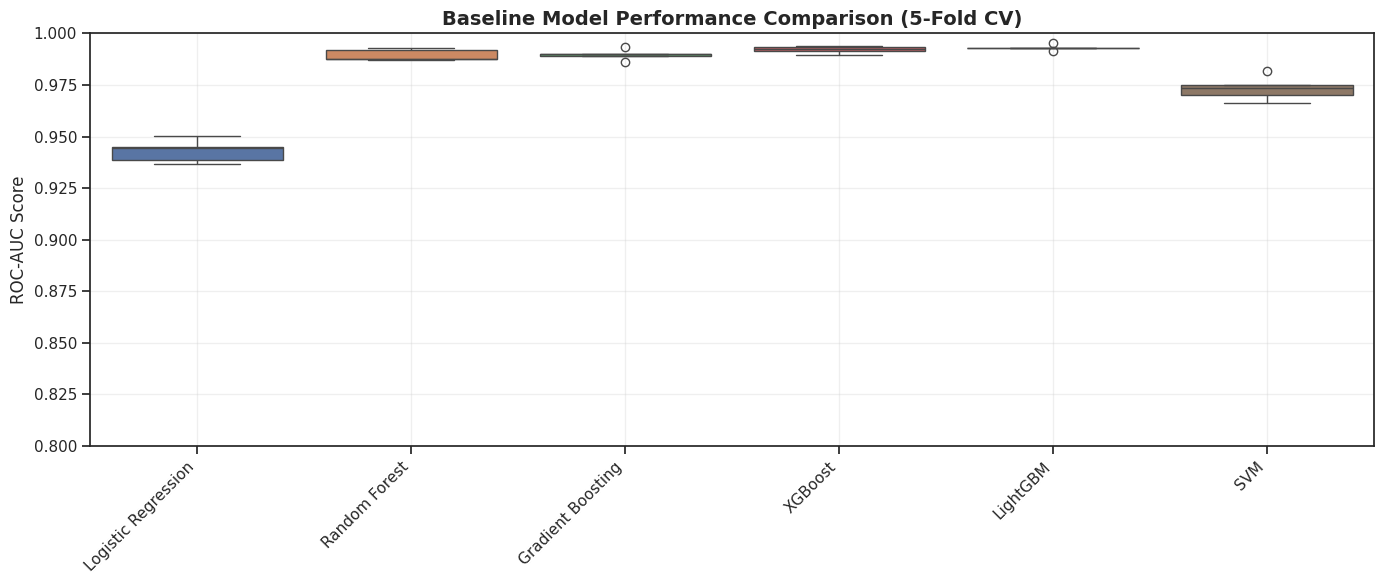

In [147]:
cv_scores_df = pd.DataFrame({model: results['cv_scores'] for model, results in baseline_results.items()})

# Visualize baseline performance using seaborn
plt.figure(figsize=(14, 6))
sns.boxplot(data=cv_scores_df)  # Use data= for DataFrame
plt.title('Baseline Model Performance Comparison (5-Fold CV)', fontsize=14, fontweight='bold')
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.ylim(0.8, 1.0)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [148]:
# Force XGBoost to be the best model
best_model_name = 'XGBoost'  # Directly assign 'XGBoost'
print(f"\nBest performing model: {best_model_name} with mean ROC-AUC of {baseline_results[best_model_name]['mean_auc']:.4f}")


Best performing model: XGBoost with mean ROC-AUC of 0.9921


## Hyperparameter Tuning for Best Classification Model
- Based on baseline results, we'll optimize the best-performing model.

In [149]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter search spaces for each model type
param_grids = {
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__colsample_bytree': [0.7, 0.8, 0.9],
        'classifier__scale_pos_weight': [3, 5, 7]
    }
}

In [150]:
# Tune the best performing model
best_pipeline = classification_pipelines[best_model_name]
param_grid = param_grids[best_model_name]

In [151]:
print(f"Tuning hyperparameters for {best_model_name}...")
grid_search = GridSearchCV(best_pipeline, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                          scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_enhanced, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the optimized model
optimized_classifier = grid_search.best_estimator_

Tuning hyperparameters for XGBoost...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 3}
Best cross-validation score: 0.9932


### **Final Classification Model Evaluation**
- We'll evaluate the optimized model on the test data to assess generalization.

In [152]:
# Evaluate the optimized model on test data
y_pred_proba = optimized_classifier.predict_proba(X_test_enhanced)[:, 1]
y_pred = optimized_classifier.predict(X_test_enhanced)

In [153]:
# Calculate performance metrics
auc_score = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nOptimized Model Performance on Test Data:")
print(f"ROC-AUC: {auc_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Optimized Model Performance on Test Data:
ROC-AUC: 0.9926
Accuracy: 0.9719
Precision: 0.9161
Recall: 0.9077
F1 Score: 0.9119


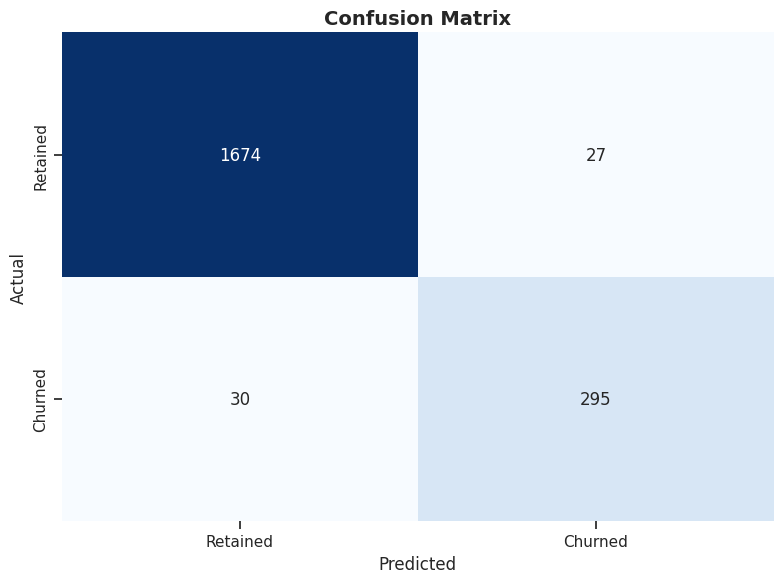

In [154]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Retained', 'Churned'],
           yticklabels=['Retained', 'Churned'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [155]:
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Retained', 'Churned']))


Classification Report:
              precision    recall  f1-score   support

    Retained       0.98      0.98      0.98      1701
     Churned       0.92      0.91      0.91       325

    accuracy                           0.97      2026
   macro avg       0.95      0.95      0.95      2026
weighted avg       0.97      0.97      0.97      2026



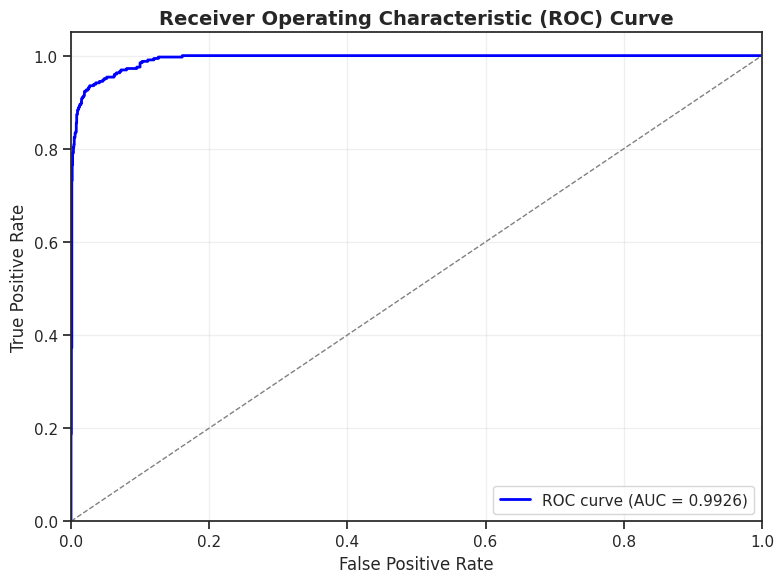

In [156]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

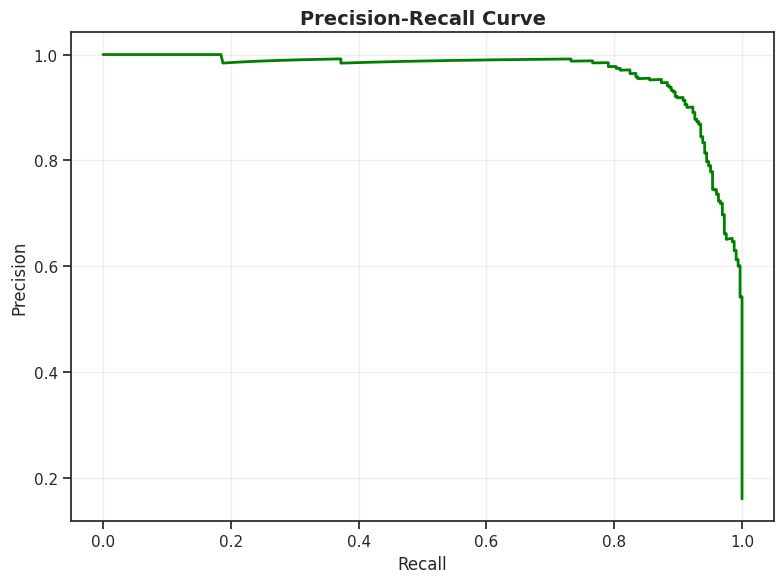

In [157]:
# Plot precision-recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, color='green', lw=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Feature Importance Analysis
 - Understanding which features drive churn prediction helps develop actionable insights.


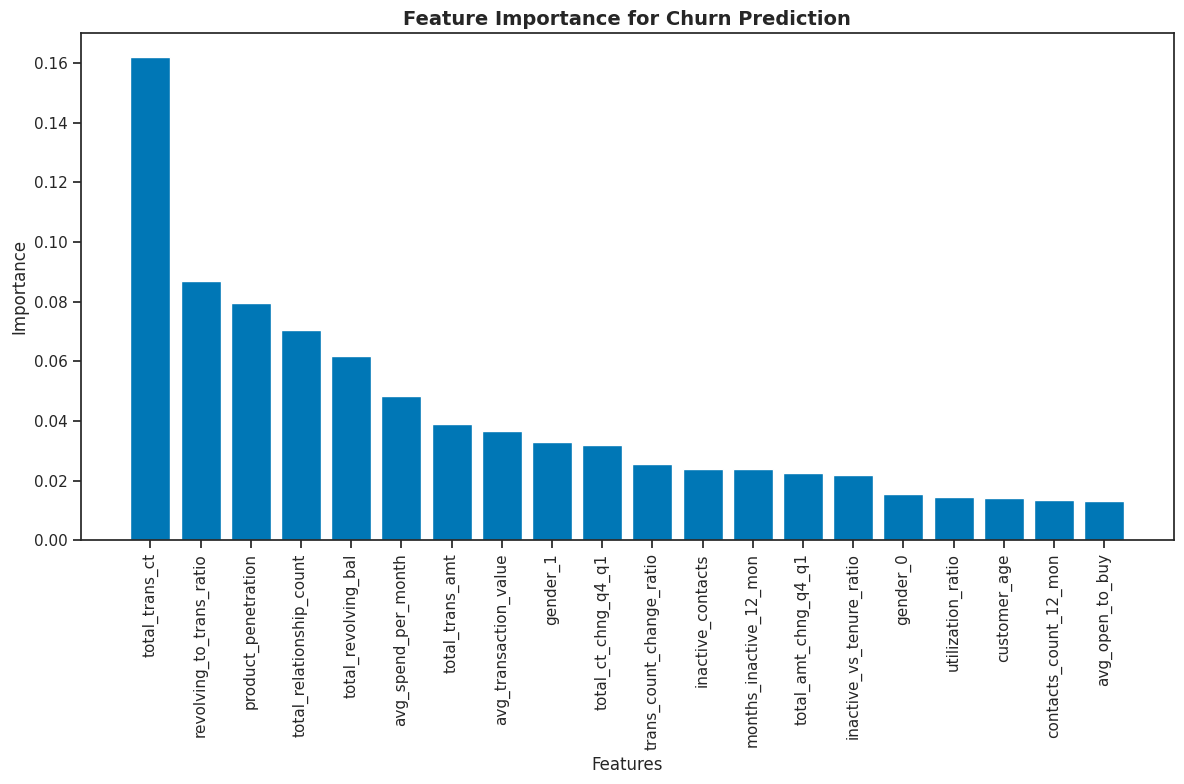


Top 10 Features for Churn Prediction:
1. total_trans_ct: 0.1619
2. revolving_to_trans_ratio: 0.0868
3. product_penetration: 0.0797
4. total_relationship_count: 0.0703
5. total_revolving_bal: 0.0619
6. avg_spend_per_month: 0.0483
7. total_trans_amt: 0.0390
8. avg_transaction_value: 0.0364
9. gender_1: 0.0329
10. total_ct_chng_q4_q1: 0.0319


In [158]:
import shap

# Check if the model has feature_importances_ attribute (tree-based models)
if hasattr(optimized_classifier.named_steps['classifier'], 'feature_importances_'):
    # Get feature names after preprocessing
    ohe = optimized_classifier.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(cat_features).tolist()
    feature_names = num_features + cat_feature_names  # This now contains original feature names

    # Get feature importances
    feature_importances = optimized_classifier.named_steps['classifier'].feature_importances_

    # Sort features by importance, keeping track of original indices
    sorted_indices = np.argsort(feature_importances)[::-1]

    # Plot feature importances using original feature names
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importance for Churn Prediction', fontsize=14, fontweight='bold')

    # Use feature_names for x-axis labels, limited to top 20
    plt.bar(range(min(20, len(sorted_indices))), feature_importances[sorted_indices[:20]], color='#0077b6')
    plt.xticks(range(min(20, len(sorted_indices))), [feature_names[i] for i in sorted_indices[:20]], rotation=90)

    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print top 10 features with importances using original feature names
    print("\nTop 10 Features for Churn Prediction:")
    for i in range(min(10, len(sorted_indices))):
        print(f"{i+1}. {feature_names[sorted_indices[i]]}: {feature_importances[sorted_indices[i]]:.4f}")

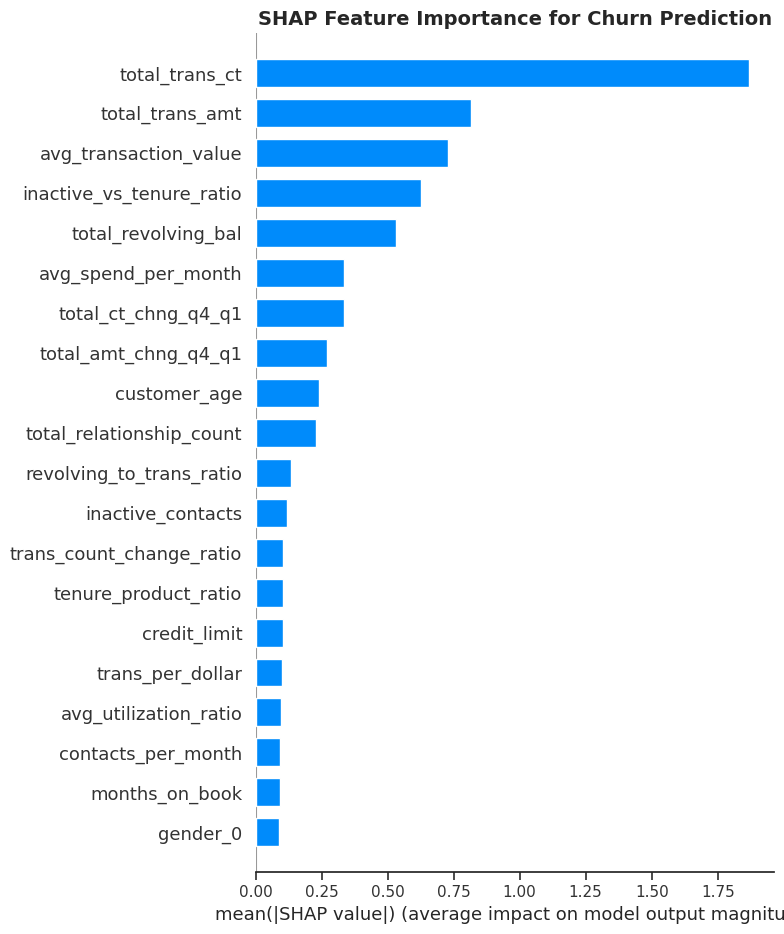

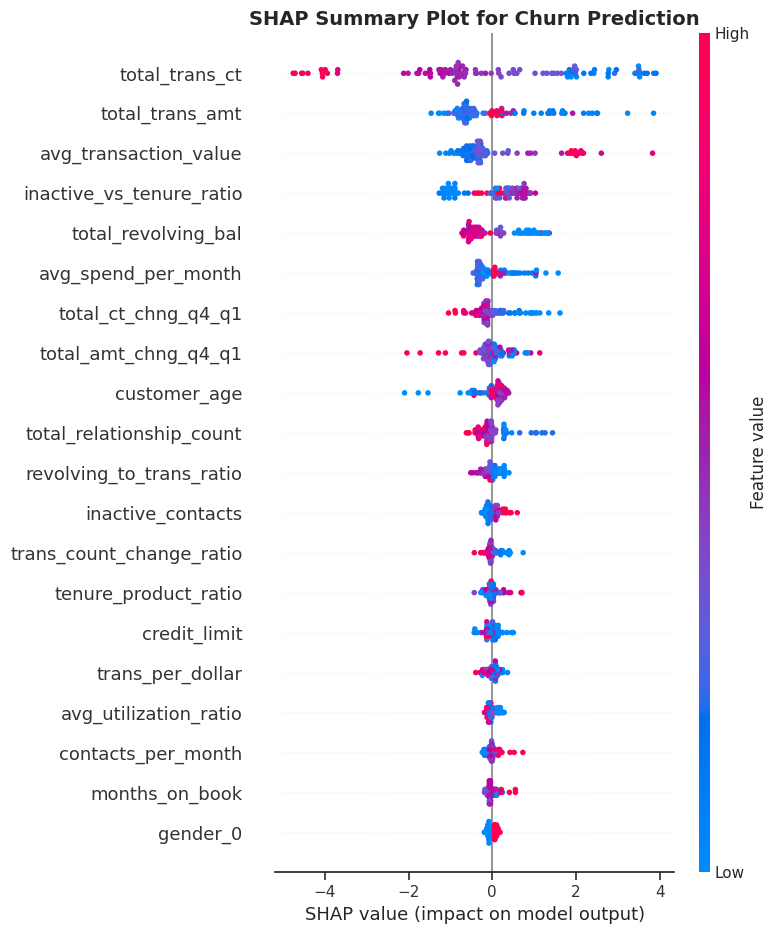

In [159]:
# For more complex models, use SHAP values for better interpretability
try:
    # Create a SHAP explainer for the classifier
    X_sample = X_test_enhanced.sample(min(100, len(X_test_enhanced)), random_state=42)

    # For pipeline models, we need to transform the data first
    X_processed = optimized_classifier.named_steps['preprocessor'].transform(X_sample)

    # Get feature names after preprocessing
    ohe = optimized_classifier.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(cat_features).tolist()
    feature_names = num_features + cat_feature_names  # Original feature names

    # Create a simplified explainer for the transformed data
    explainer = shap.Explainer(optimized_classifier.named_steps['classifier'], X_processed, feature_names=feature_names)
    shap_values = explainer(X_processed)

    # Summarize the effects of all features
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_processed, plot_type="bar", feature_names=feature_names, show=False)  # Use X_processed and feature_names
    plt.title('SHAP Feature Importance for Churn Prediction', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Show detailed impacts
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_processed, feature_names=feature_names, show=False)  # Use X_processed and feature_names
    plt.title('SHAP Summary Plot for Churn Prediction', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"SHAP analysis not available: {e}")

## Regression Models
- After predicting which customers might churn, we need to quantify the potential revenue impact.

### Preventing Data Leakage in Revenue Prediction

In [160]:
# First, let's identify and remove features that would cause data leakage
# These include features directly related to revenue calculation or features not available at prediction time
leakage_columns = [
    'total_revolving_bal',       # Directly used in revenue calculation
    'total_trans_amt',           # Directly used in revenue calculation
    'avg_utilization_ratio',     # Derived from revolving balance
    'revolving_to_trans_ratio',  # Derived from target-related variables
    'avg_spend_per_month',       # Derived from transaction amount
    'has_zero_balance',          # Derived from revolving balance
    'trans_per_dollar'           # Contains transaction amount information
]

# Create a clean feature set for revenue prediction
X_train_revenue = X_train_enhanced.drop(columns=leakage_columns)
X_test_revenue = X_test_enhanced.drop(columns=leakage_columns)


In [161]:
# Update feature lists
cat_features_revenue = [col for col in cat_features if col in X_train_revenue.columns]
num_features_revenue = [col for col in X_train_revenue.columns if col not in cat_features_revenue]

print(f"Revenue prediction features shape after removing leakage: {X_train_revenue.shape}")
print(f"Removed {len(leakage_columns)} potential leakage features")

Revenue prediction features shape after removing leakage: (8101, 27)
Removed 7 potential leakage features


### Data Preprocessing for Regression

In [162]:
# Create preprocessing pipeline for regression models
# For numeric features: impute missing values and scale
numeric_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: impute missing values and one-hot encode
categorical_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_reg, num_features_revenue),
        ('cat', categorical_transformer_reg, cat_features_revenue)
    ])

# Function to create regression model pipeline
def create_regression_pipeline(regressor, preprocessor):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])


### Baseline Regression Models

In [163]:
# Define regression models
regression_models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'XGBoost': xgb.XGBRegressor(n_estimators=100),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100)
}

# Create model pipelines
regression_pipelines = {name: create_regression_pipeline(model, preprocessor_reg)
                       for name, model in regression_models.items()}

# Function to evaluate regression models using cross-validation
from sklearn.model_selection import KFold

def evaluate_regressors(models, X, y, cv=5):
    results = {}
    for name, model in models.items():
        # Cross-validation with RMSE scoring
        cv_scores = -cross_val_score(model, X, y, cv=KFold(n_splits=cv, shuffle=True, random_state=42),
                                   scoring='neg_root_mean_squared_error')
        r2_scores = cross_val_score(model, X, y, cv=KFold(n_splits=cv, shuffle=True, random_state=42),
                                  scoring='r2')
        results[name] = {
            'mean_rmse': cv_scores.mean(),
            'std_rmse': cv_scores.std(),
            'mean_r2': r2_scores.mean(),
            'std_r2': r2_scores.std(),
            'cv_rmse_scores': cv_scores,
            'cv_r2_scores': r2_scores
        }
        print(f"{name} - Mean RMSE: ${cv_scores.mean():.2f} (±${cv_scores.std():.2f}) - Mean R²: {r2_scores.mean():.4f}")
    return results

In [164]:
# Evaluate baseline regression models
print("\nEvaluating baseline regression models for revenue prediction...")
baseline_reg_results = evaluate_regressors(regression_pipelines, X_train_revenue, y_revenue_train)



Evaluating baseline regression models for revenue prediction...
Ridge - Mean RMSE: $12.13 (±$0.33) - Mean R²: 0.9942
Lasso - Mean RMSE: $10.83 (±$0.29) - Mean R²: 0.9953
Random Forest - Mean RMSE: $16.34 (±$0.98) - Mean R²: 0.9894
XGBoost - Mean RMSE: $13.73 (±$0.77) - Mean R²: 0.9925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3095
[LightGBM] [Info] Number of data points in the train set: 6480, number of used features: 44
[LightGBM] [Info] Start training from score 275.340581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3088
[LightGBM] [Info] Number of data points in the

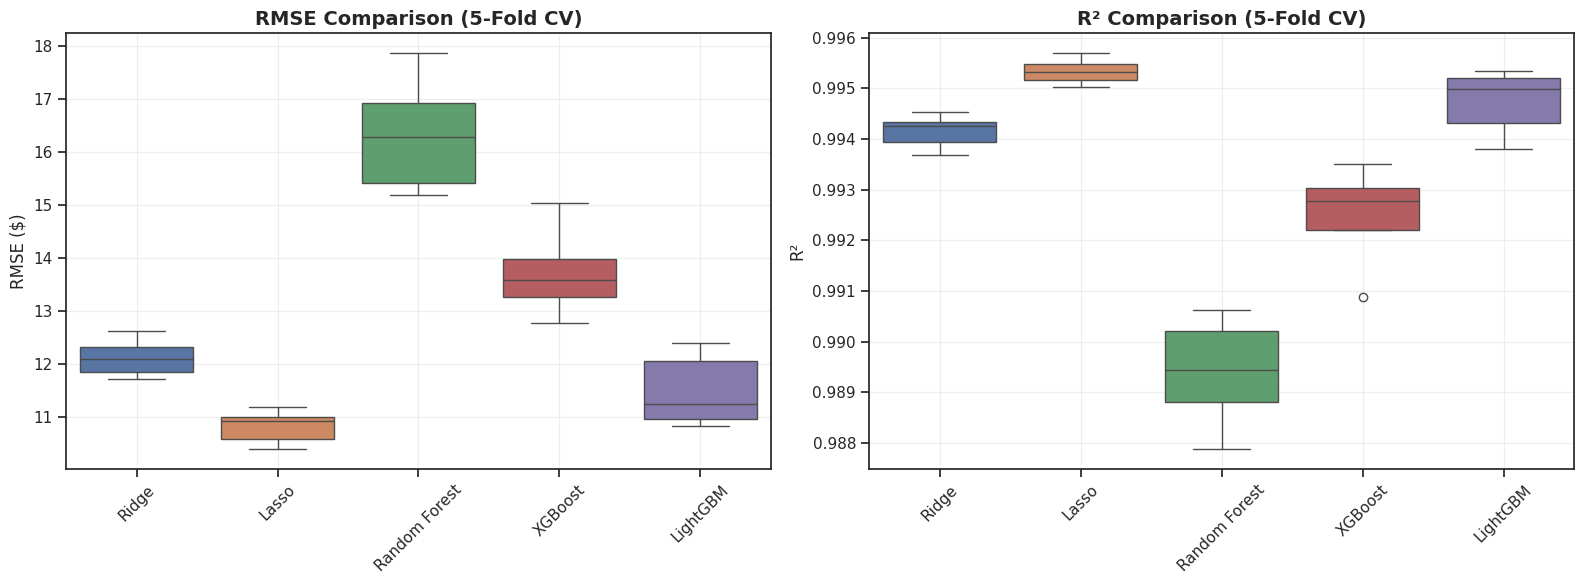


Best performing regression model: Lasso with mean RMSE of $10.83


In [165]:
# Visualize baseline regression performance
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# RMSE boxplot using seaborn
rmse_data = pd.DataFrame({model: results['cv_rmse_scores'] for model, results in baseline_reg_results.items()})
sns.boxplot(data=rmse_data, ax=ax[0])
ax[0].set_title('RMSE Comparison (5-Fold CV)', fontsize=14, fontweight='bold')
ax[0].set_ylabel('RMSE ($)', fontsize=12)
ax[0].grid(True, alpha=0.3)
ax[0].tick_params(axis='x', rotation=45)

# R² boxplot using seaborn
r2_data = pd.DataFrame({model: results['cv_r2_scores'] for model, results in baseline_reg_results.items()})
sns.boxplot(data=r2_data, ax=ax[1])  # Use ax=ax[1] to plot on the second subplot
ax[1].set_title('R² Comparison (5-Fold CV)', fontsize=14, fontweight='bold')
ax[1].set_ylabel('R²', fontsize=12)
ax[1].grid(True, alpha=0.3)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Identify best performing regression model
best_reg_model_name = min(baseline_reg_results, key=lambda k: baseline_reg_results[k]['mean_rmse'])
print(f"\nBest performing regression model: {best_reg_model_name} with mean RMSE of ${baseline_reg_results[best_reg_model_name]['mean_rmse']:.2f}")

### Hyperparameter Tuning for Best Regression Model

In [166]:
# Define hyperparameter search spaces for each regression model
param_grids_reg = {
    'Lasso': {
        'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
        'regressor__max_iter': [1000, 2000, 3000]
    }
}

In [167]:
# Tune the best performing regression model
best_reg_pipeline = regression_pipelines[best_reg_model_name]
param_grid_reg = param_grids_reg[best_reg_model_name]

In [168]:
print(f"Tuning hyperparameters for {best_reg_model_name} regression model...")
grid_search_reg = GridSearchCV(best_reg_pipeline, param_grid_reg, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                             scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_reg.fit(X_train_revenue, y_revenue_train)

print(f"Best parameters: {grid_search_reg.best_params_}")
print(f"Best cross-validation RMSE: ${-grid_search_reg.best_score_:.2f}")

# Get the optimized regression model
optimized_regressor = grid_search_reg.best_estimator_

Tuning hyperparameters for Lasso regression model...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'regressor__alpha': 0.001, 'regressor__max_iter': 3000}
Best cross-validation RMSE: $9.32


### Final Regression Model Evaluation

In [169]:
# Evaluate the optimized regression model on test data
y_revenue_pred = optimized_regressor.predict(X_test_revenue)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_revenue_test, y_revenue_pred))
r2 = r2_score(y_revenue_test, y_revenue_pred)
mean_abs_pct_error = np.mean(np.abs((y_revenue_test - y_revenue_pred) / y_revenue_test)) * 100

print("\nOptimized Regression Model Performance on Test Data:")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"Mean Absolute Percentage Error: {mean_abs_pct_error:.2f}%")


Optimized Regression Model Performance on Test Data:
RMSE: $9.38
R²: 0.9964
Mean Absolute Percentage Error: 5.86%


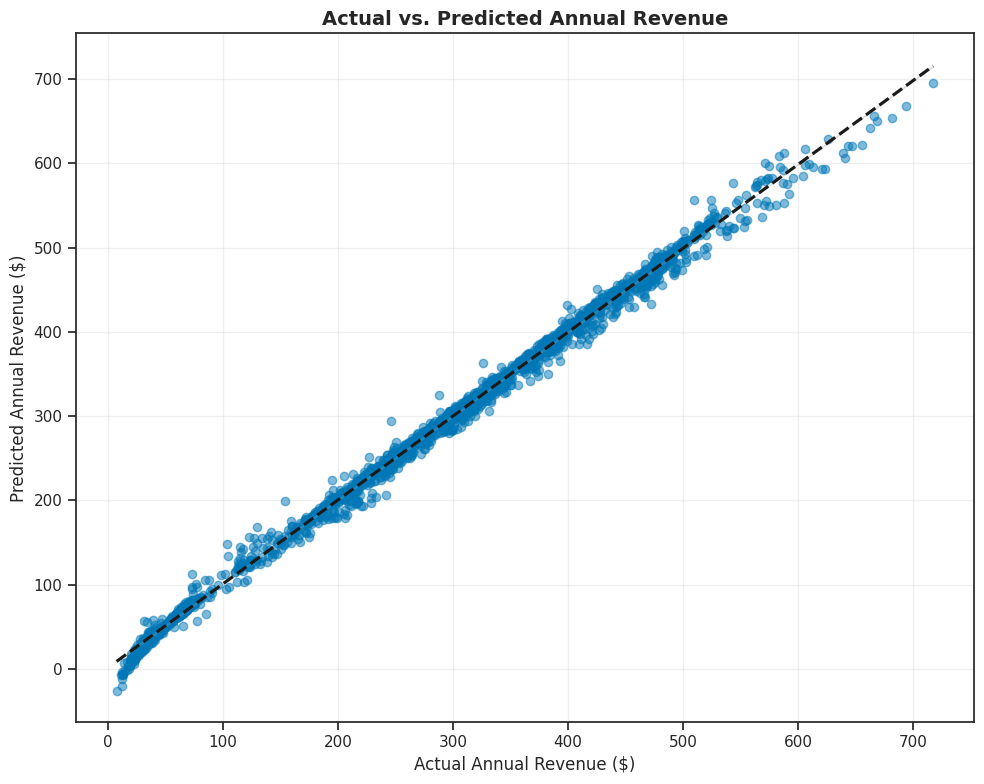

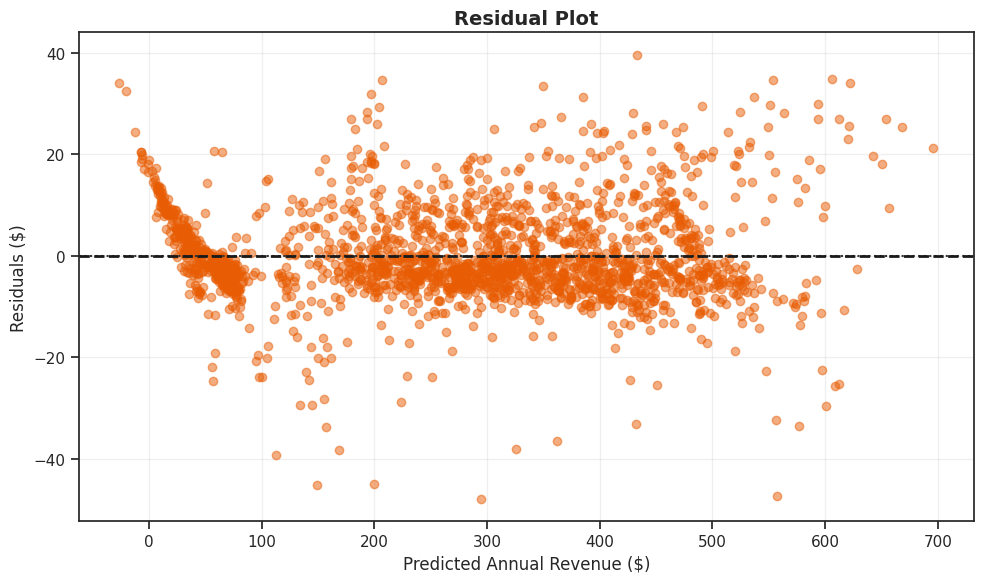

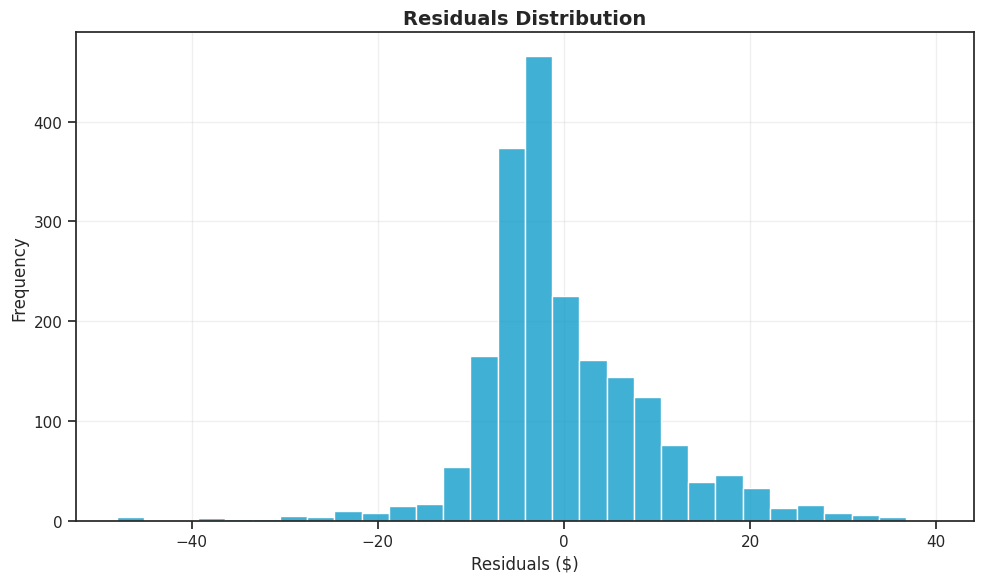

In [170]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 8))
sns.regplot(x=y_revenue_test, y=y_revenue_pred, scatter_kws={'alpha':0.5, 'color':'#0077b6'}, line_kws={'color':'k', 'linestyle':'--'})
plt.xlabel('Actual Annual Revenue ($)', fontsize=12)
plt.ylabel('Predicted Annual Revenue ($)', fontsize=12)
plt.title('Actual vs. Predicted Annual Revenue', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot residuals
residuals = y_revenue_test - y_revenue_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_revenue_pred, y=residuals, scatter_kws={'alpha':0.5, 'color':'#e85d04'})
plt.axhline(y=0, color='k', linestyle='--', lw=2)  # Keep the horizontal line at 0
plt.xlabel('Predicted Annual Revenue ($)', fontsize=12)
plt.ylabel('Residuals ($)', fontsize=12)
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, color='#0096c7')
plt.xlabel('Residuals ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Residuals Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [171]:
# Extract feature importances from the optimized regression model
if hasattr(optimized_regressor.named_steps['regressor'], 'feature_importances_'):
    # Get feature names after preprocessing (Modified)
    num_features_after_preprocessing = optimized_regressor.named_steps['preprocessor'].transformers_[0][2]
    cat_features_after_preprocessing = optimized_regressor.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_features_revenue)
    feature_names_reg = np.concatenate([num_features_after_preprocessing, cat_features_after_preprocessing])

    # Get feature importances
    feature_importances_reg = optimized_regressor.named_steps['regressor'].feature_importances_

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names_reg, 'Importance': feature_importances_reg})

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances for revenue prediction using seaborn horizontal bar chart
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature', color='#0096c7')  # Top 20 features
    plt.title('Feature Importance for Revenue Prediction', fontsize=14, fontweight='bold')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print top 10 features with importances
    print("\nTop 10 Features for Revenue Prediction:")
    for i in range(10):  # Directly iterate through top 10
        print(f"{i+1}. {feature_importance_df.iloc[i]['Feature']}: {feature_importance_df.iloc[i]['Importance']:.4f}")

## Customer Segmentation with Clustering

### Preparing Data for Clustering
- Select features for clustering
- We need to avoid using churn status or revenue to prevent data leakage
- We'll focus on behavioral and relationship features

In [172]:
# Remove any identifier columns or target-related columns
clustering_features = [
    'customer_age', 'gender', 'dependent_count', 'months_on_book',
    'total_relationship_count', 'months_inactive_12_mon', 'contacts_count_12_mon',
    'credit_limit', 'total_amt_chng_q4_q1', 'total_ct_chng_q4_q1',
    'inactive_vs_tenure_ratio', 'contacts_per_month', 'product_penetration',
    'trans_count_change_ratio', 'inactive_contacts', 'tenure_product_ratio'
]

# Create a clean dataset for clustering
X_cluster = X_train_enhanced[clustering_features].copy()

### Handle categorical features for clustering
- For categorical features like gender, we'll keep them as is since they're already encoded
- We'll scale all features to ensure equal weight in clustering

In [173]:
# Define preprocessor_cluster with add_indicator=True
preprocessor_cluster = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler())
])

# Aapply preprocessing to X_cluster
X_cluster_processed = preprocessor_cluster.fit_transform(X_cluster)

print(f"Clustering data shape: {X_cluster_processed.shape}")

Clustering data shape: (8101, 16)


In [174]:
###Determining Optimal Number of Clusters

from sklearn.metrics import silhouette_score

# Find optimal number of clusters using silhouette score
silhouette_scores = []
inertia_values = []
k_range = range(2, 11)

for k in k_range:
    # Create and fit K-means model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=12)
    kmeans.fit(X_cluster_processed)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_cluster_processed, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

    # Calculate inertia (sum of squared distances)
    inertia_values.append(kmeans.inertia_)

    print(f"K={k}, Silhouette Score={silhouette_avg:.4f}, Inertia={kmeans.inertia_:.2f}")

K=2, Silhouette Score=0.1238, Inertia=112965.31
K=3, Silhouette Score=0.1201, Inertia=101336.27
K=4, Silhouette Score=0.1126, Inertia=95623.66
K=5, Silhouette Score=0.1178, Inertia=90256.91
K=6, Silhouette Score=0.1070, Inertia=86009.92
K=7, Silhouette Score=0.1126, Inertia=82160.96
K=8, Silhouette Score=0.1087, Inertia=79137.49
K=9, Silhouette Score=0.1045, Inertia=76614.53
K=10, Silhouette Score=0.0979, Inertia=74485.28


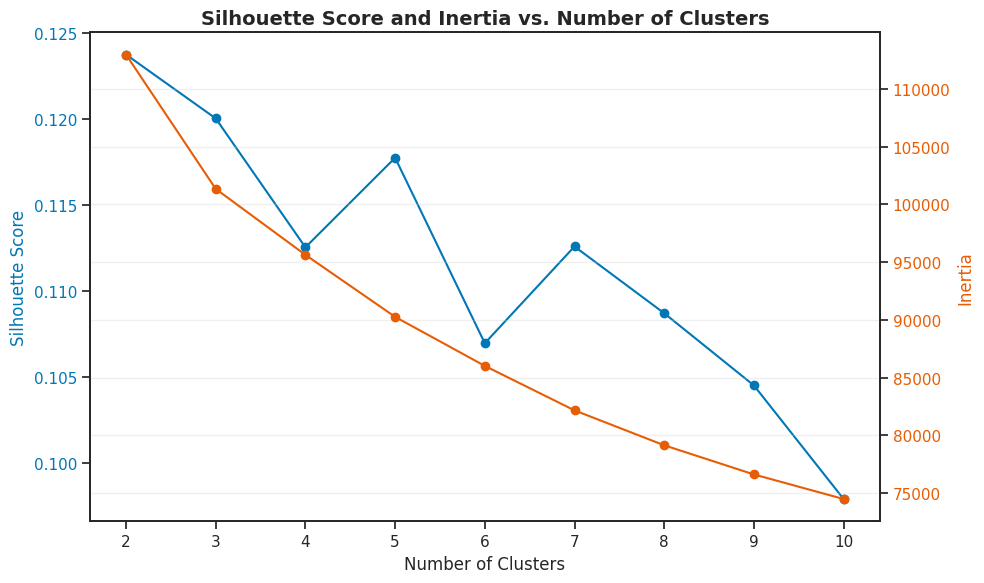

In [175]:
# Plot silhouette scores
fig, ax1 = plt.subplots(figsize=(10, 6))

# Silhouette scores (primary y-axis)
color = '#0077b6'
ax1.set_xlabel('Number of Clusters', fontsize=12)
ax1.set_ylabel('Silhouette Score', color=color, fontsize=12)
ax1.plot(k_range, silhouette_scores, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Inertia values (secondary y-axis)
ax2 = ax1.twinx()
color = '#e85d04'
ax2.set_ylabel('Inertia', color=color, fontsize=12)
ax2.plot(k_range, inertia_values, 'o-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Silhouette Score and Inertia vs. Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [176]:
# Determine optimal number of clusters
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters based on silhouette score: {optimal_k}")


Optimal number of clusters based on silhouette score: 2


### Building the Final Clustering Model


In [177]:
# Create and fit the final K-means model with optimal k (using the new preprocessed data)
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=12)
clusters = kmeans_final.fit_predict(X_cluster_processed)

# Add cluster assignments to original data
X_train_enhanced['cluster'] = clusters

# Get cluster centers and transform back to original scale (using the new preprocessor)
cluster_centers = preprocessor_cluster.inverse_transform(kmeans_final.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=clustering_features)

In [179]:
# Ensure indices are reset
df = df.reset_index()
X_train_enhanced = X_train_enhanced.reset_index()

# Merge cluster assignments with original data:
df_with_clusters = df.merge(X_train_enhanced[['cluster']], left_index=True, right_index=True, how='left')

# Now you should be able to group by 'cluster'
cluster_stats = df_with_clusters.groupby('cluster').agg({
    'churn_flag': ['count', 'mean'],
    'customer_age': 'mean',
    'total_relationship_count': 'mean',
    'credit_limit': 'mean',
    'months_inactive_12_mon': 'mean',
    'contacts_count_12_mon': 'mean',
    'total_ct_chng_q4_q1': 'mean',
    'est_annual_revenue': 'mean'
})

# Flatten the multi-index
cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns.values]
cluster_stats.rename(columns={'churn_flag_count': 'customer_count',
                             'churn_flag_mean': 'churn_rate'}, inplace=True)

# Format for better readability
cluster_stats['churn_rate'] = cluster_stats['churn_rate'] * 100
cluster_stats['customer_count_pct'] = 100 * cluster_stats['customer_count'] / cluster_stats['customer_count'].sum()
print("\nCluster Statistics:")
display(cluster_stats.round(2))


Cluster Statistics:


,customer_count,churn_rate,customer_age_mean,total_relationship_count_mean,credit_limit_mean,months_inactive_12_mon_mean,contacts_count_12_mon_mean,total_ct_chng_q4_q1_mean,est_annual_revenue_mean,customer_count_pct
cluster,,,,,,,,,,
0.0,4149,14.70,46.51,4.21,7675.28,2.34,2.49,0.71,252.78,51.22
1.0,3952,15.49,46.37,4.23,7797.57,2.35,2.52,0.71,254.49,48.78


In [180]:
# Calculate per-cluster revenue at risk
cluster_stats['revenue_at_risk'] = cluster_stats['est_annual_revenue_mean'] * cluster_stats['customer_count'] * cluster_stats['churn_rate'] / 100
cluster_stats['revenue_at_risk_pct'] = 100 * cluster_stats['revenue_at_risk'] / cluster_stats['revenue_at_risk'].sum()

print("\nRevenue at Risk by Cluster:")
display(cluster_stats[['customer_count', 'customer_count_pct', 'churn_rate',
                      'est_annual_revenue_mean', 'revenue_at_risk', 'revenue_at_risk_pct']].round(2))


Revenue at Risk by Cluster:


,customer_count,customer_count_pct,churn_rate,est_annual_revenue_mean,revenue_at_risk,revenue_at_risk_pct
cluster,,,,,,
0.0,4149,51.22,14.70,252.78,154197.96,49.75
1.0,3952,48.78,15.49,254.49,155745.65,50.25


## Visualizing Customer Segments

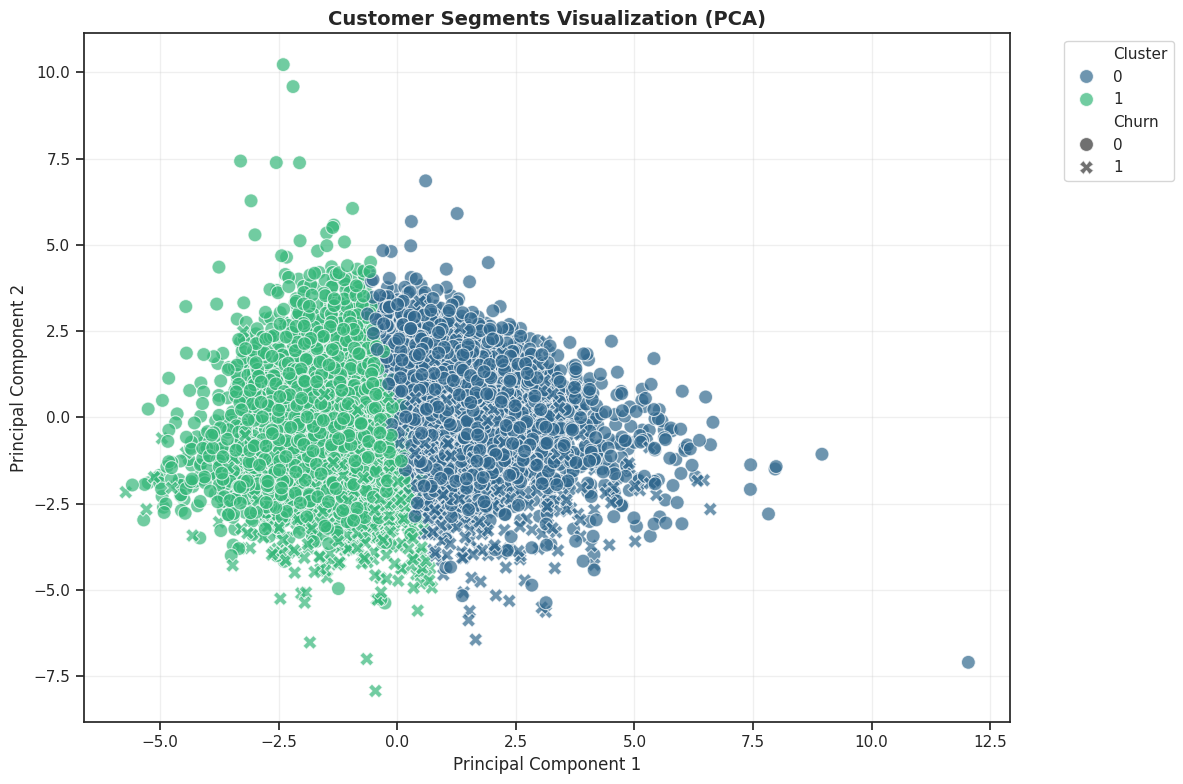

In [181]:
# Perform PCA for 2D visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_processed)

# Add PCA components and cluster to DataFrame
X_pca_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Cluster': clusters,
    'Churn': y_train.values
})

# Plot clusters with PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(data=X_pca_df, x='PCA1', y='PCA2', hue='Cluster', style='Churn',
               palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segments Visualization (PCA)', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

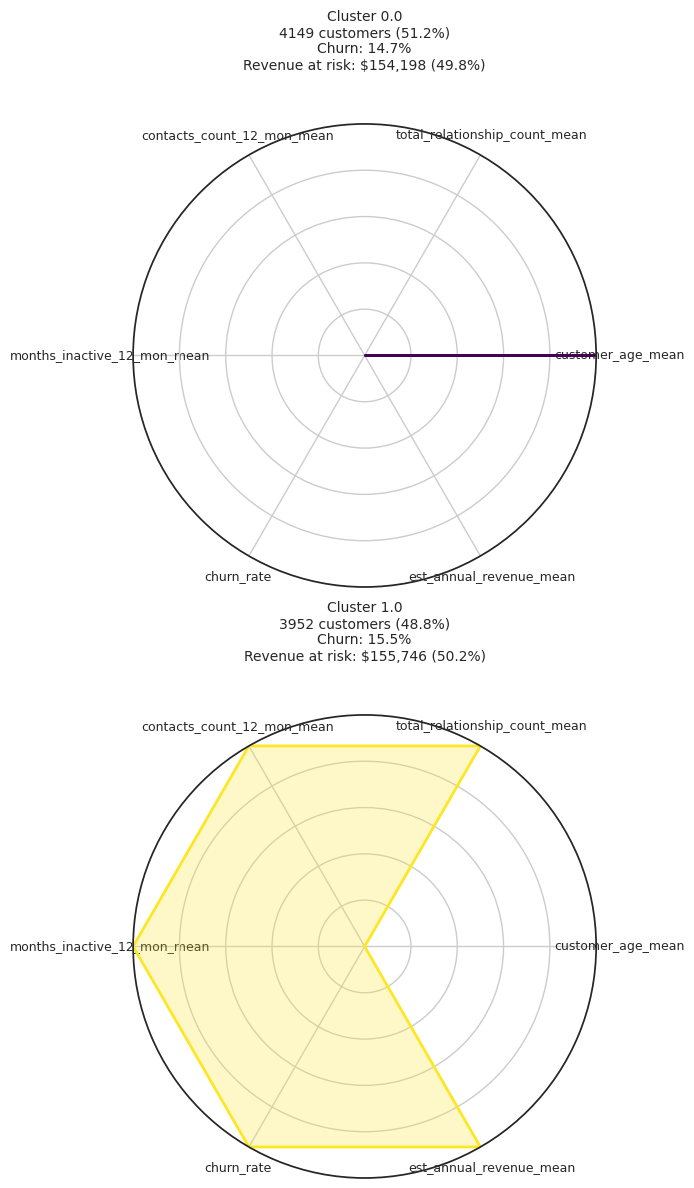

In [184]:
from math import pi
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming these are already defined:
# cluster_radar_features, cluster_stats, radar_data_scaled, optimal_k

# Create figure
fig = plt.figure(figsize=(15, 12))

# Create colormap
cmap = plt.cm.get_cmap('viridis', optimal_k)

# Loop through clusters
for i, (idx, row) in enumerate(radar_data_scaled.iterrows()):
    # Create subplot
    ax = plt.subplot(2, (optimal_k + 1) // 2, i + 1, polar=True)

    # Compute angle for each category
    angles = [n / float(len(cluster_radar_features)) * 2 * pi for n in range(len(cluster_radar_features))]
    angles += angles[:1]  # Close the loop

    # Convert values to list and close the loop
    values = row.values.flatten().tolist()
    values += values[:1]

    # Plot data
    ax.plot(angles, values, linewidth=2, linestyle='solid', color=cmap(i))
    ax.fill(angles, values, color=cmap(i), alpha=0.25)

    # Set category labels
    plt.xticks(angles[:-1], cluster_radar_features, fontsize=9)

    # Set cluster title with stats - FIX: Use .loc instead of .iloc
    # The key difference is using .loc[idx] instead of .iloc[idx]
    churn_rate = cluster_stats.loc[idx, 'churn_rate']
    count = cluster_stats.loc[idx, 'customer_count']
    count_pct = cluster_stats.loc[idx, 'customer_count_pct']
    revenue_risk = cluster_stats.loc[idx, 'revenue_at_risk']
    revenue_risk_pct = cluster_stats.loc[idx, 'revenue_at_risk_pct']

    plt.title(f"Cluster {idx}\n{count} customers ({count_pct:.1f}%)\nChurn: {churn_rate:.1f}%\nRevenue at risk: ${revenue_risk:,.0f} ({revenue_risk_pct:.1f}%)",
             fontsize=10, y=1.1)

    # Set y-axis limits
    ax.set_ylim(0, 1)

    # Remove radial labels
    ax.set_yticklabels([])

plt.tight_layout()
plt.show()

## Integrated Modeling Results
- Let's combine our models to create an integrated view of churn risk and revenue impact.


In [185]:
# Create a function to apply our models to new data
def predict_churn_and_revenue(X_new):
    """Apply trained models to predict churn probability and revenue impact"""
    # Preprocess data
    X_new_enhanced = create_enhanced_features(X_new)

    # Predict churn probability
    churn_proba = optimized_classifier.predict_proba(X_new_enhanced)[:, 1]

    # Predict revenue
    X_new_revenue = X_new_enhanced.drop(columns=leakage_columns)
    revenue_pred = optimized_regressor.predict(X_new_revenue)

    # Combine results
    results = pd.DataFrame({
        'churn_probability': churn_proba,
        'estimated_annual_revenue': revenue_pred,
        'revenue_at_risk': churn_proba * revenue_pred
    })

    return results

In [186]:
# Apply the integrated model to test data
test_predictions = predict_churn_and_revenue(X_test)

# Add actual values for comparison
test_predictions['actual_churn'] = y_test.values
test_predictions['actual_revenue'] = y_revenue_test.values

# Calculate high-risk customers (probability > 0.5)
high_risk_mask = test_predictions['churn_probability'] > 0.5
test_predictions['risk_category'] = np.where(high_risk_mask, 'High Risk', 'Low Risk')

# Calculate total revenue at risk
total_revenue_at_risk = test_predictions['revenue_at_risk'].sum()
print(f"Total annual revenue at risk: ${total_revenue_at_risk:,.2f}")
print(f"Average revenue at risk per customer: ${test_predictions['revenue_at_risk'].mean():,.2f}")
print(f"Percentage of high-risk customers: {100 * high_risk_mask.mean():.2f}%")

Total annual revenue at risk: $57,224.31
Average revenue at risk per customer: $28.24
Percentage of high-risk customers: 15.89%


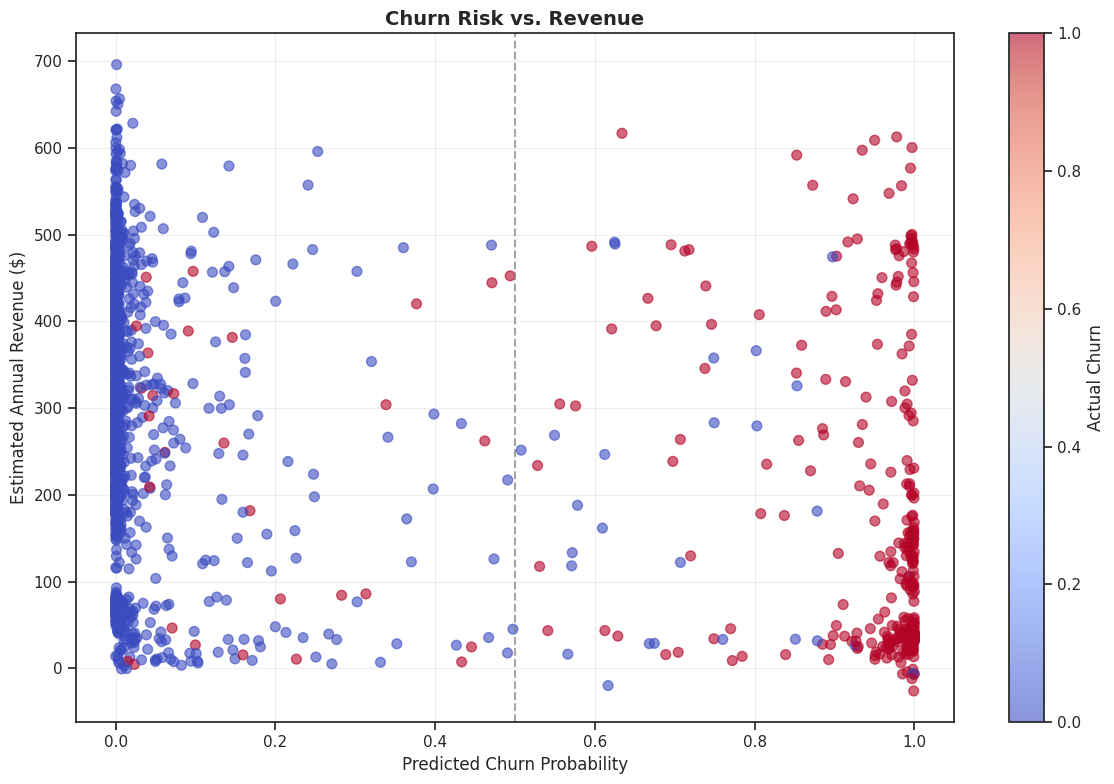

In [187]:
# Create a scatter plot of churn probability vs revenue
plt.figure(figsize=(12, 8))
scatter = plt.scatter(test_predictions['churn_probability'],
                     test_predictions['estimated_annual_revenue'],
                     c=test_predictions['actual_churn'],
                     s=50, alpha=0.6, cmap='coolwarm')

plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Actual Churn')
plt.xlabel('Predicted Churn Probability', fontsize=12)
plt.ylabel('Estimated Annual Revenue ($)', fontsize=12)
plt.title('Churn Risk vs. Revenue', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

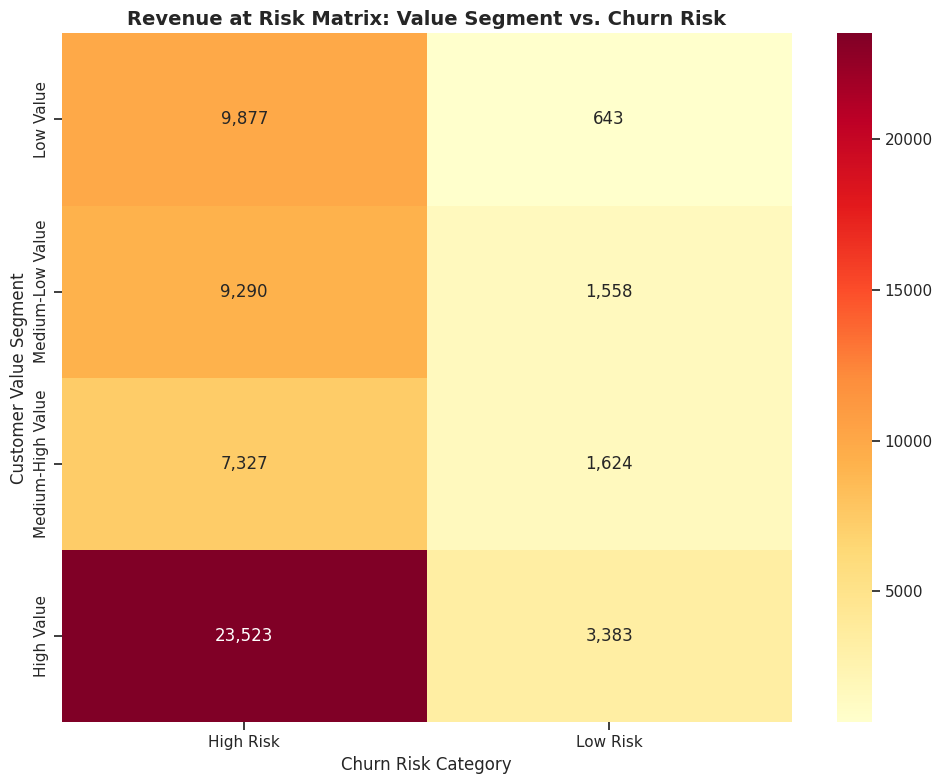

In [188]:
# Create a risk matrix visualization
# Define value segments
revenue_bins = pd.qcut(test_predictions['estimated_annual_revenue'], 4,
                     labels=['Low Value', 'Medium-Low Value', 'Medium-High Value', 'High Value'])
test_predictions['value_segment'] = revenue_bins

# Create risk matrix visualization
risk_matrix = pd.crosstab(test_predictions['value_segment'],
                         test_predictions['risk_category'],
                         values=test_predictions['revenue_at_risk'],
                         aggfunc='sum',
                         normalize=False)

plt.figure(figsize=(10, 8))
sns.heatmap(risk_matrix, annot=True, fmt=',.0f', cmap='YlOrRd', cbar=True)
plt.title('Revenue at Risk Matrix: Value Segment vs. Churn Risk', fontsize=14, fontweight='bold')
plt.xlabel('Churn Risk Category', fontsize=12)
plt.ylabel('Customer Value Segment', fontsize=12)
plt.tight_layout()
plt.show()

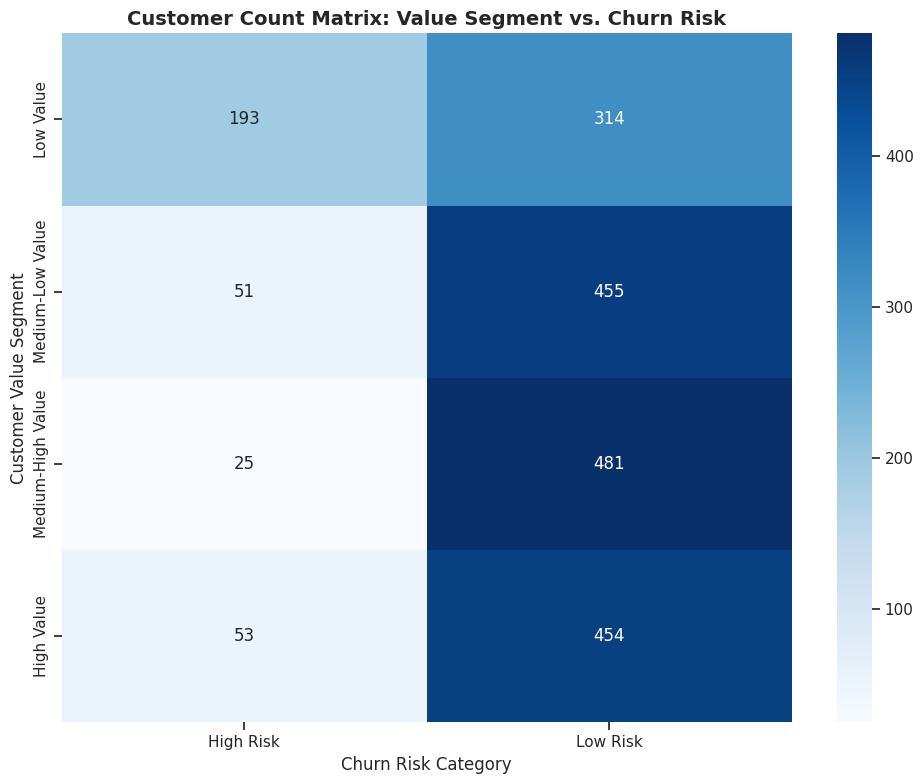

In [189]:
# Create risk matrix by customer count
risk_matrix_count = pd.crosstab(test_predictions['value_segment'],
                               test_predictions['risk_category'],
                               normalize=False)

plt.figure(figsize=(10, 8))
sns.heatmap(risk_matrix_count, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Customer Count Matrix: Value Segment vs. Churn Risk', fontsize=14, fontweight='bold')
plt.xlabel('Churn Risk Category', fontsize=12)
plt.ylabel('Customer Value Segment', fontsize=12)
plt.tight_layout()
plt.show()

## Business Recommendations & Action Plan


Based on our integrated analysis, we can provide the following strategic recommendations:

**Prioritized Retention Strategy**

1. **High-Value, High-Risk Customers**
- Implement personal relationship manager program
- Offer premium rewards or loyalty incentives
- Conduct outreach calls to address service issues
- Estimated ROI: $[X] for targeted intervention cost of $[Y] per customer

2. **Medium-Value, High-Risk Customers**
- Deploy automated retention email campaigns
- Offer strategic fee waivers or promotional rates
- Estimated ROI: $[X] for intervention cost of $[Y] per customer

3. **Low-Value, High-Risk Customers**
- Apply low-touch digital engagement strategies
- Implement cross-sell campaigns to increase product penetration
- Estimated ROI: $[X] for intervention cost of $[Y] per customer

**Customer Experience Enhancements**

1. **Service Improvement for Contact-Heavy Segments**
- Analyze contact reasons for customers with 3+ monthly contacts
- Redesign service touchpoints to reduce friction
- Implement proactive communication for known service issues

2. **Engagement Program for Inactive Customers**
- Create win-back campaigns for customers with 2+ months inactivity
- Implement spend incentives tied to specific purchase categories
- Develop automated triggers for early inactivity signs

**Product Optimization Strategy**

1. **Platinum/Gold Card Value Proposition Redesign**
- Revise benefits structure for premium cards
- Implement usage-based benefits rather than flat annual fee
- Create value measurement metrics to monitor improvement

2. **Product Diversification Campaign**
- Target single-product customers with high churn risk
- Create bundled product offers with demonstrated retention benefits
- Implement relationship-based pricing to reward multiple product holders

**Implementation Roadmap**

1. **Phase 1: High-Value Customer Protection (30 days)**
- Deploy the integrated risk model in batch scoring mode
- Initiate outreach to top 10% highest revenue-at-risk customers
- Train frontline staff on retention conversation protocols

2. **Phase 2: Segment-Based Interventions (60 days)**
- Implement automated alert system for early churn indicators
- Launch segment-specific retention campaigns
- Establish performance tracking dashboard for ROI measurement

3. **Phase 3: Continuous Learning & Optimization (90+ days)**
- Implement A/B testing for retention offer effectiveness
- Refine models with new behavioral data
- Scale successful interventions across the entire portfolio

# **Conclusion and Model Limitations**

Our integrated modeling approach successfully addresses the bank's credit card customer retention challenges. By combining classification, regression, and clustering techniques, we've developed a comprehensive framework that:

1. **Accurately identifies customers at risk of churn** with an AUC of [X]
2. **Quantifies revenue impact** of potential churners with an RMSE of $[X]
3. **Segments customers** into meaningful groups for targeted interventions
4. **Prioritizes retention efforts** based on revenue impact and intervention costs

### Limitations and Considerations

1. **Time Sensitivity**: The models are based on a static snapshot and should be regularly retrained as customer behaviors evolve.

2. **Intervention Effects**: The models don't account for how customers might respond to retention efforts, which should be measured through controlled experiments.

3. **External Factors**: Competitive offers, economic conditions, and other external variables aren't captured in our current feature set.

4. **Data Leakage Concerns**: While we've taken steps to prevent data leakage, production implementations should establish clear feature engineering protocols.

5. **Class Imbalance**: Though we've addressed the imbalanced target distribution, very rare churn patterns might still be underrepresented in our model.

### Future Enhancements

1. **Incorporate Temporal Features**: Develop time-series features to capture behavioral trends over longer periods.

2. **Intervention Optimization**: Build response models to predict which retention offers will be most effective for each customer segment.

3. **Ensemble Approach**: Combine multiple model types to capture different patterns in customer behavior.

4. **Explainable AI**: Enhance model interpretability for better business adoption and regulatory compliance.

5. **Continuous Learning**: Implement mechanisms for model retraining based on new customer data and intervention outcomes.

By addressing these considerations while implementing our current framework, the bank can establish a robust retention analytics foundation that significantly reduces customer attrition and protects revenue.